# Évaluez et améliorez les performances d'un modèle de machine learning

## I. Comprenez ce qui fait un bon modèle d’apprentissage

*Comment faire pour choisir l’algorithme et les hyperparamètres qui permettent de construire le modèle le plus adapté à mon problème ?*

**Compromis biais-variance** : Un modèle simple (variance faible) risque le **sous-apprentissage** (biais élevé y compris sur les données d’entraînement). Un modèle complexe (variance élevée) risque le **sur-apprentissage** (biais faible sur les données d’entraînement mais élevé sur de nouvelles données). On souhaite trouver un modèle intermédiaire, vers le creux de la courbe orange, là où le biais de prédiction est le plus faible et la **généralisation** la meilleure.

Attention ! Vous pouvez être amenés à faire des compromis sur la complexité d’un modèle pour respecter des contraintes sur le temps de calcul (que ce soit pour l’entraînement ou pour la prédiction) ou les ressources en mémoire.

## II. Mettez en place un cadre de validation croisée

*Comment peut-on mesurer la performance d’un modèle sur des données inconnues ?*

**La validation croisée** va nous permettre d’utiliser l'intégralité de notre jeu de données pour l’entraînement et pour la validation. On découpe le jeu de données en k parties (folds en anglais) à peu près égales. Tour à tour, chacune des k parties est utilisée comme jeu de test. Le reste (autrement dit, l’union des k-1 autres parties) est utilisé pour l'entraînement.

J'ai donc 1 prédiction par point de mon jeu initial, et aucune de ces prédictions n'a été faite avec un jeu d'entraînement qui contienne ce point. Je n'ai pas violé le principe de ne pas valider sur le jeu d'entraînement !

Je peux finalement rapporter la performance de mon modèle :

- soit en évaluant les prédictions faites sur l’ensemble des données (puisque j’ai fait une prédiction par point du jeu de données complet) ;

- soit en moyennant les performances obtenues sur les k folds, auquel cas je peux aussi rapporter l’erreur type, pour quantifier la variation de ces performances sur les k folds.

**La stratification** : dans le cas d’un problème de classification, on s’efforce généralement de créer les k folds de sorte à ce qu’elles contiennent à peu près les mêmes proportions d’exemples de chaque classe que le jeu de données complet
(**model_selection.StratifiedKFold**)

*Comment choisir le nombre de folds, k ?* 
 - **le leave-one-out** : on ne laisse de côté qu’un seul exemple pour chaque jeu d’entraînement --> forte augmentation du temps de calcul
 - En pratique k=5 ou k=10
 

## III. Sélectionnez le nombre de voisins dans un kNN

In [37]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('data course/winequality-white.csv', sep=";")
print(data.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

In [39]:
#features 
X = data.as_matrix(data.columns[:-1])


#ariable to be explained
y = data.as_matrix([data.columns[-1]])
y = y.flatten()

y_class = np.where(y<6, 0, 1)

In [40]:
#Séparation Train/Test
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_class,test_size=0.3)

In [41]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

**KNN**

In [70]:
from sklearn import neighbors, metrics

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf_knn = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), # un classifieur kNN
param_grid, # hyperparamètres à tester
cv=5, # nombre de folds de validation croisée
scoring=score # score à optimiser
)

# Optimiser ce classifieur sur le jeu d'entraînement
# clf.fit(X_train, y_train)
clf_knn.fit(X_train_std, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",
      clf_knn.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :",'\n')

for mean, std, params in zip(clf_knn.cv_results_['mean_test_score'], # score moyen
                             clf_knn.cv_results_['std_test_score'], # écart-type du score
                             clf_knn.cv_results_['params'] # valeur de l'hyperparamètre
                            ):
    print("\t%s = %0.3f (+/-%0.03f) for %r" % (score, # critère utilisé
                                                mean, # score moyen
                                                std * 2, # barre d'erreur
                                                params # hyperparamètre
                                                ))

y_pred = clf_knn.predict(X_test_std)
print("\nSur le jeu de test : %0.3f" % metrics.accuracy_score(y_test, y_pred))
#print("\nSur le jeu de test : %0.3f" % metrics.f1_score(y_test, y_pred))

metrics.confusion_matrix(y_test, y_pred)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'n_neighbors': 11}
Résultats de la validation croisée : 

	accuracy = 0.754 (+/-0.027) for {'n_neighbors': 3}
	accuracy = 0.750 (+/-0.028) for {'n_neighbors': 5}
	accuracy = 0.749 (+/-0.031) for {'n_neighbors': 7}
	accuracy = 0.757 (+/-0.031) for {'n_neighbors': 9}
	accuracy = 0.760 (+/-0.032) for {'n_neighbors': 11}
	accuracy = 0.758 (+/-0.027) for {'n_neighbors': 13}
	accuracy = 0.758 (+/-0.037) for {'n_neighbors': 15}

Sur le jeu de test : 0.759


array([[257, 195],
       [159, 859]], dtype=int64)

**Logistic Regression**

In [71]:
#Regression Logistique par défault
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

clf_LogReg = LogisticRegression()

clf_LogReg.fit(X_train_std, y_train)

y_pred = clf_LogReg.predict(X_test_std)

print("Accuracy","sur le jeu de test : %0.3f" % metrics.accuracy_score(y_test, y_pred))

metrics.confusion_matrix(y_test, y_pred)

Accuracy sur le jeu de test : 0.767


array([[245, 207],
       [135, 883]], dtype=int64)

In [64]:
from sklearn.linear_model import LogisticRegressionCV

clf_LogRegCV = LogisticRegressionCV(cv=model_selection.StratifiedKFold(n_splits=5))

clf_LogRegCV.fit(X_train_std, y_train)

y_pred = clf_LogRegCV.predict(X_test_std)

print("Accuracy","sur le jeu de test : %0.3f" % metrics.accuracy_score(y_test, y_pred))

# confusion_matrix = confusion_matrix(y_test, y_pred)

# print(confusion_matrix)

Accuracy  sur le jeu de test : 0.766


In [69]:
# Fixer les valeurs des hyperparamètres à tester
param_grid =  {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Créer un classifieur LR avec recherche d'hyperparamètre par validation croisée
clf_LogRegCV_grid = model_selection.GridSearchCV(LogisticRegression(penalty='l2'),
                                                 param_grid=param_grid, # hyperparamètres à tester
                                                 cv=10, # nombre de folds de validation croisée
                                                 scoring=score # score à optimiser
                                                )

clf_LogRegCV_grid.fit(X_train_std, y_train)

y_pred = clf_LogRegCV_grid.predict(X_test_std)

print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",
      clf_LogRegCV_grid.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :",'\n')

for mean, std, params in zip(clf_LogRegCV_grid.cv_results_['mean_test_score'], # score moyen
                             clf_LogRegCV_grid.cv_results_['std_test_score'], # écart-type du score
                             clf_LogRegCV_grid.cv_results_['params'] # valeur de l'hyperparamètre
                            ):
    print("\t%s = %0.3f (+/-%0.03f) for %r" % (score, # critère utilisé
                                                mean, # score moyen
                                                std * 2, # barre d'erreur
                                                params # hyperparamètre
                                                ))
    
print("Accuracy","sur le jeu de test : %0.3f" % metrics.accuracy_score(y_test, y_pred))

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'C': 1}
Résultats de la validation croisée : 

	accuracy = 0.723 (+/-0.040) for {'C': 0.001}
	accuracy = 0.739 (+/-0.039) for {'C': 0.01}
	accuracy = 0.743 (+/-0.035) for {'C': 0.1}
	accuracy = 0.744 (+/-0.037) for {'C': 1}
	accuracy = 0.743 (+/-0.039) for {'C': 10}
	accuracy = 0.743 (+/-0.039) for {'C': 100}
	accuracy = 0.743 (+/-0.039) for {'C': 1000}
Accuracy sur le jeu de test : 0.767


## I. Évaluez un algorithme de classification qui retourne des valeurs binaires


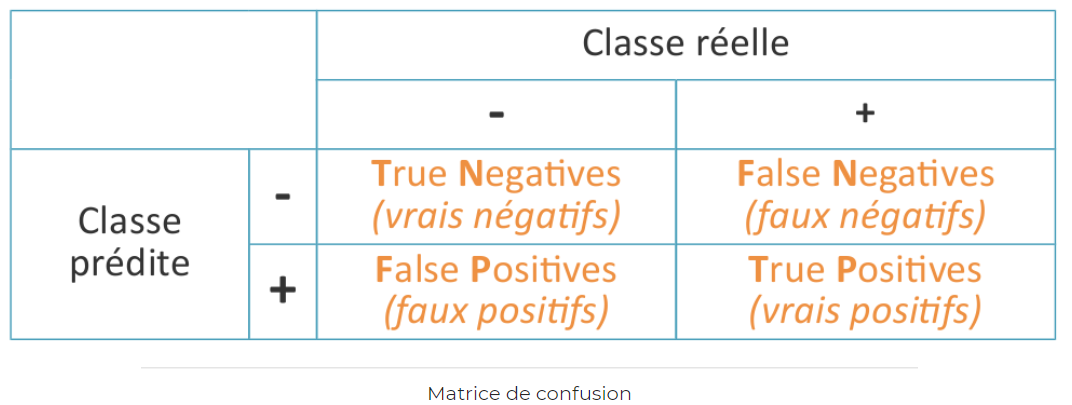

**metrics.confusion_matrix(y_true, y_pred)**

**Critères à optimiser et valeurs dérivées**

**Le rappel** ("recall"  en anglais), ou sensibilité ("sensitivity" en anglais), est le taux de vrais positifs, c’est à dire la proportion de positifs que l’on a correctement identifiés. C’est la capacité de notre modèle à détecter tous les incendies.

**Rappel = TP / (TP + FN)**

**La précision** corespond à la proportion de prédictions correctes parmi les points que l’on a prédits positifs. C’est la capacité de notre modèle à ne déclencher d’alarme que pour un vrai incendie. 

**Précision = TP/(TP+FP)**

Pour évaluer un compromis entre rappel et précision, on peut calculer **la "F-mesure"**, qui est leur moyenne harmonique.

**F−mesure=2×(Précision×Rappel)/(Précision+Rappel)=2TP/(2TP+FP+FN)**

Pour finir cette longue liste, on s’intéresse aussi souvent à **la spécificité** ("specificity" en anglais), qui est le taux de vrais négatifs, autrement dit la capacité à détecter toutes les  situations où il n’y a pas d’incendie. C’est une mesure complémentaire de la sensibilité. 

**Spécificité=TN/(FP+TN)**

Toutes ces mesures de performance sont disponibles dans le module **metrics** de scikit-learn.

La **Courbe ROC** est une courbe construite pour montrer comment la sensibilité évolue en fonction de la spécificité (en fait, de 1 moins la spécificité, que l'on appelle parfois antispécificité).

On peut résumer la courbe ROC par un nombre : **"l'aire sous la courbe"**, aussi dénotée **AUROC** pour « Area Under the ROC », qui permet plus aisément de comparer plusieurs modèles.

Un classifieur parfait a une AUROC de 1 ; un classifieur aléatoire, une AUROC de 0.5

AUROC: 0.8110319557695985


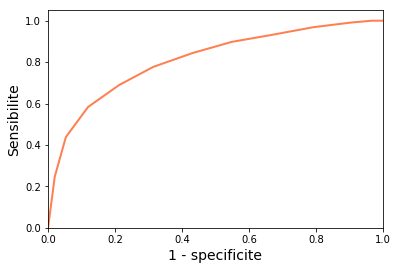

In [75]:
y_pred_proba = clf.predict_proba(X_test_std)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite', fontsize=14)
plt.ylabel('Sensibilite', fontsize=14)

print("AUROC:", metrics.auc(fpr, tpr))

In [79]:
idx = np.min(np.where(tpr > 0.80)) # indice du premier seuil pour lequel
                                   # la sensibilité est supérieure à 0.80
print("Sensibilité : %.2f" % tpr[idx])
print("Spécificité : %.2f" % (1-fpr[idx]))
print("Seuil : %.2f" % thr[idx])

Sensibilité : 0.84
Spécificité : 0.57
Seuil : 0.55


Une autre courbe fréquemment utilisée est la **courbe précision-rappel** (précision en ordonnée et rappel en abscisse), souvent appelée **« PR curve »**.

**La courbe lift**, surtout utilisée dans le ciblage marketing, se construit aussi en parcourant le jeu de données ordonné par score. 
On représente en abscisse la fraction du jeu de données parcourue, et en ordonnée le taux de vrais positifs.

## II. Comparez votre algorithme à des approches de classification naïves

Pour mieux comprendre la difficulté de notre problème, et évaluer les performances que l'on peut facilement atteindre, on peut utiliser des approches naïves : des approches très simples mais qui s'appuient néanmoins sur le jeu de données pour construire un modèle. Ces méthodes ne permettent pas réellement de faire de l'apprentissage, mais servent de point de comparaison pour évaluer nos modèles.

Voici quelques approches naïves pour des problèmes de classification. Elles sont implémentées dans la classe  DummyClassifier  du module  dummy  de scikit-learn.

- Prédire la même classe pour tous les échantillons : la classe la plus fréquente dans le jeu d'entraînement. Cette approche naïve nous permet d’évaluer si le modèle que nous proposons a appris « plus » que simplement quelle est la classe la plus fréquente. C’est particulièrement intéressant si une des classes est beaucoup plus fréquente que les autres. Pensez que pour un problème de classification binaire sur des données contenant 90% d’échantillons positifs, un classifieur qui retourne systématiquement « positif » aura une accuracy de 90%.

- Prédire une classe aléatoirement, dans les mêmes proportions que dans le jeu d'entraînement. Cette approche naïve nous permet d’évaluer si les performances que nous observons ne seraient pas simplement dûes aux proportions relatives des classes.

- Retourner aléatoirement des scores selon une distribution uniforme, puis leur appliquer un seuil pour obtenir une prédiction binaire. Cette méthode est recommandée quand on cherche à interpréter une courbe ROC ou une AUROC, elles-mêmes construites à partir de classifieurs qui retournent des scores.

## I.  Evaluez un algorithme de régression